<div class="head0">
    <div class="head0__name">
        Equation with linear drift in 1D case
    </div>
    <div class="head0__note">
        Solution of the 1D Fokker-Planck equation with linear drift (Ornstein–Uhlenbeck process with known analytic solution) in standard numpy format.
    </div>
</div>

In [1]:
import sys

import numpy as np

sys.path.extend(['./../lib', './../helpers'])
from solver import Solver
from solvers_check import SolversCheck
from helpers import init_jupyter

data_path = './data/eq-1d_drift-linear_analyt'
init_jupyter()

Start |  5:38PM MSK on Sep 19, 2019 |
-------------------------------------


<div class="head1">
    <div class="head1__name">
        Model problem
    </div>
</div>

Consider
$$
    d x = f(x, t) \, dt + S(x, t) \, d \beta,
    \quad
    d \beta \, d \beta^{\top} = Q(t) dt,
    \quad
    x(0) = x_0 \sim \rho(x, 0) = \rho_0 (x),
$$
$$
    \frac{\partial \rho(x, t)}{\partial t} =
        \sum_{i=1}^d \sum_{j=1}^d
            \frac{\partial^2}{\partial x_i \partial x_j}
            \left[ D_{ij}(x, t) \rho(x, t) \right]
        - \sum_{i=1}^d
            \frac{\partial}{\partial x_i}
            \left[ f_i(x, t) \rho(x, t) \right],
    \quad
     D(x, t) = \frac{1}{2} S(x, t) Q(t) S(x, t)^{\top},
$$
where spatial $d$-dimensional ($d \ge 1$) variable $x \in R^d$ has probability density function (PDF) $\rho(x, t)$, $\beta$ is Brownian motion of dimension $q$ ($q \ge 1$, and we assume below that $q = d$), $f(x, t) \in R^d$ is a vector-function, $S(x, t) \in R^{d \times q}$ and $Q(t) \in R^{q \times q}$ are matrix-functions and $D(x, t) \in R^{d \times d}$ is a diffusion tensor.

Let
$$
    Q(t) \equiv I,
    \,
    S(x, t) \equiv I
    \implies
    D(x, t) \equiv \frac{1}{2} I,
$$
and
$$
    d = 1,
    \quad
    x \in \Omega,
    \quad
    \rho(x, t) |_{\partial \Omega} \approx 0,
    \quad
    f(x, t) = A (\mu - x),
    \quad
    \mu \equiv 0,
    \quad
    \rho_0(x) = \frac{1}{\sqrt{2 \pi s}}\exp{\left[-\frac{x^2}{2s}\right]}.
$$

This equation has exact solution for the $d$-dimensional case ([see this paper](https://advancesindifferenceequations.springeropen.com/articles/10.1186/s13662-019-2214-1))
$$
    \rho(x, t, x_0) =
        \frac{1}{\sqrt{ | 2 \pi \Sigma(t) | }}
        exp \left[
            -\frac{1}{2} (x - M(t, x_0))^T \Sigma^{-1}(t) (x - M(t, x_0))
        \right],
$$
where $x_0$ is an initial condition and
$$
    M(t, x_0) = e^{-A t} x_0 + \left( I - e^{-A t} \right) \mu,
$$
$$
    \Sigma(t) = \int_0^t e^{A (s-t)} S S^T e^{A^T (s-t)} \, d  s,
$$
or in a more simple form for the case $d=1$
$$
    \rho(x, t, x_0) =
        \frac{1}{\sqrt{ | 2 \pi \Sigma(t) | }}
        exp \left[
            -\frac{(x - M(t, x_0))^2}{2 \Sigma(t)}
        \right],
    \quad
    M(t, x_0) = e^{-A t} x_0,
    \quad
    \Sigma(t) = \frac{1 - e^{-2 A t}}{2 A}.
$$

We can rewrite the solution $\rho(x, t, x_0)$ in terms of the initial PDF $\rho_0(x)$ as
$$
    \rho(x, t) = \int_{-\infty}^{\infty}
        \rho(x, t, x_0) \rho_0(x_0) \, d x_0,
$$
which after accurate computations leads to the following analytic solution
$$
    \rho(x, t) =
        \frac
            {
                1
            }
            {
                \sqrt{2 \pi \left( \Sigma(t) + s e^{-2 A t} \right)}
            }
        \exp{\left[
            - \frac
                {
                    x^2
                }
                {
                    2 \left( \Sigma(t) + s e^{-2 A t} \right)
                }
        \right]},
$$
and the stationary solution ($t \rightarrow \infty$) is
$$
    \rho_{stat}(x) =
        \sqrt{
            \frac{A}{\pi}
        }
        e^{-A x^2}.
$$

<div class="note">
    The Ornstein–Uhlenbeck process is mean-reverting (the solution tends to its long-term mean $\mu$ as time $t$ tends to infinity) if $A > 0$ and this process at any time is a normal random variable.
</div>

In [2]:
def func_f0(x, t):
    return -A_coef * x

def func_f1(x, t):
    return -A_coef * np.ones(x.shape)

def func_r0(x):
    a = 2. * s_coef
    r = np.exp(-x * x / a) / np.sqrt(np.pi * a)
    return r.reshape(-1)

def func_rt(x, t):
    
    def func_xc(t):
        return (1. - np.exp(-2. * A_coef * t)) / 2. / A_coef

    S = func_xc(t) + s_coef * np.exp(-2. * A_coef * t)
    a = 2. * S
    r = np.exp(-x * x / a) / np.sqrt(np.pi * a)
    return r.reshape(-1)

def func_rs(x):
    a = 1. / A_coef
    r = np.exp(-x * x / a) / np.sqrt(np.pi * a)
    return r.reshape(-1)

<div class="head1">
    <div class="head1__name">
        Parameters
    </div>
</div>

In [3]:
s_coef = 1.
A_coef = 1.
D_coef = 0.5
t_min, t_max, t_poi = +0., +8., 1000
x_min, x_max, x_poi = -5., +5., 101

<div class="head1">
    <div class="head1__name">
        Calculation process
    </div>
</div>

In [4]:
SL = Solver(d=1)
SL.set_grid_t(t_poi, t_min, t_max, t_hst=10)
SL.set_grid_x(x_poi, x_min, x_max)
SL.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
SL.set_coefs(D_coef)

SL.prep()
SL.calc()
SL.info()

Solve: 100%|█| 999/999 [00:03<00:00, 274.45step/s, | At T=8.0e+00 : e=1.0e-05 es=1.0e-05]

----------- Solver
Format    : 1D, NP [order=2]
Grid x    : poi =       101, min =   -5.0000, max =    5.0000
Grid t    : poi =      1000, min =    0.0000, max =    8.0000 , hst =        10
Time sec  : prep = 1.79e-02, calc = 3.58e+00, spec = 6.20e-02
Err calc  : 1.00e-05 (at the point: 1.19e-05)
Err stat  : 1.01e-05 (at the point: 1.19e-05)


<div class="head1">
    <div class="head1__name">
        Solution visualization
    </div>
</div>

<div class="head2">
    <div class="head2__name">
        Solution near the boundaries
    </div>
</div>

--- Solution at spatial point
X = [-5.0e+00]


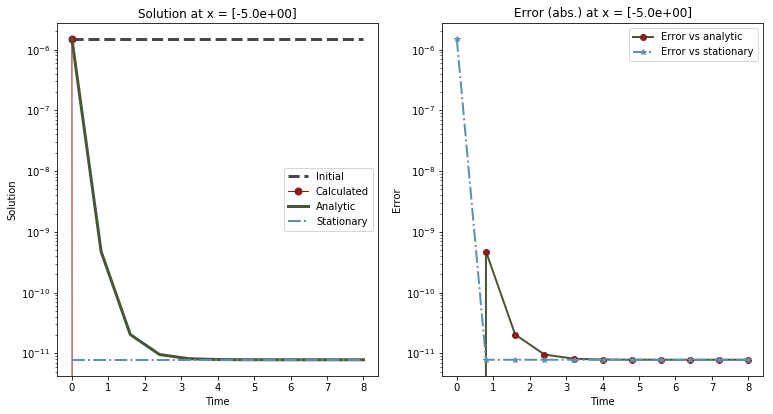

--- Solution at spatial point
X = [ 5.0e+00]


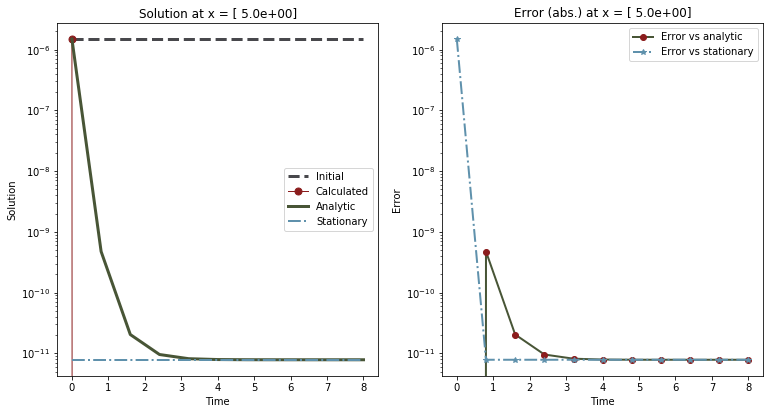

In [5]:
opts = { 'is_log': True, 'is_abs': False, 'is_err_abs': True, 'with_err_stat': True }
SL.plot_t(x_min, opts)
SL.plot_t(x_max, opts)

<div class="head2">
    <div class="head2__name">
        Solution in the inner points
    </div>
</div>

--- Solution at spatial point
X = [-2.5e+00]


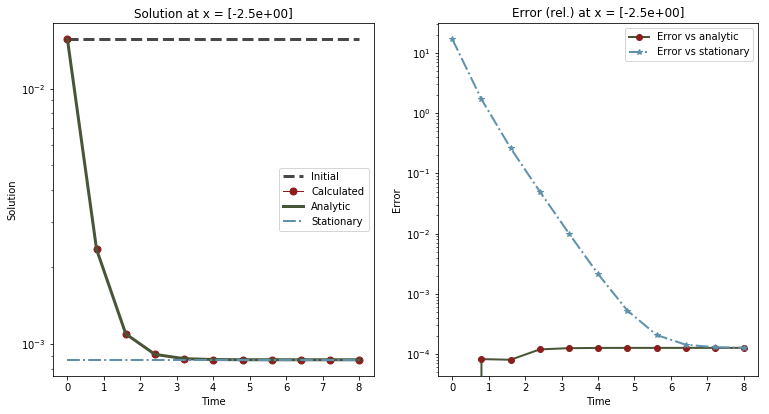

--- Solution at spatial point
X = [ 3.1e-16]


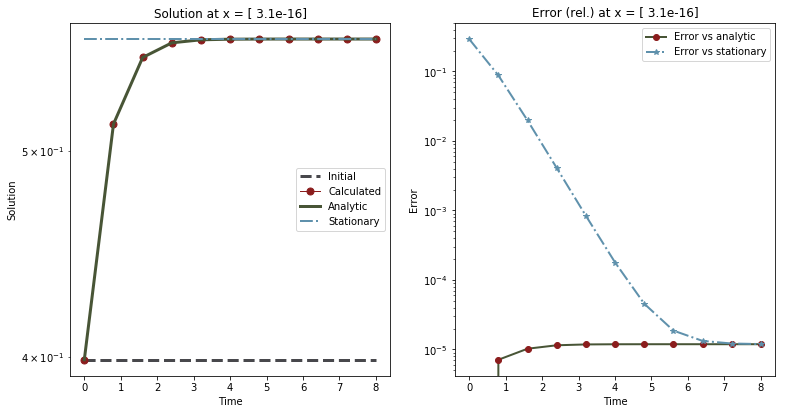

--- Solution at spatial point
X = [ 2.5e+00]


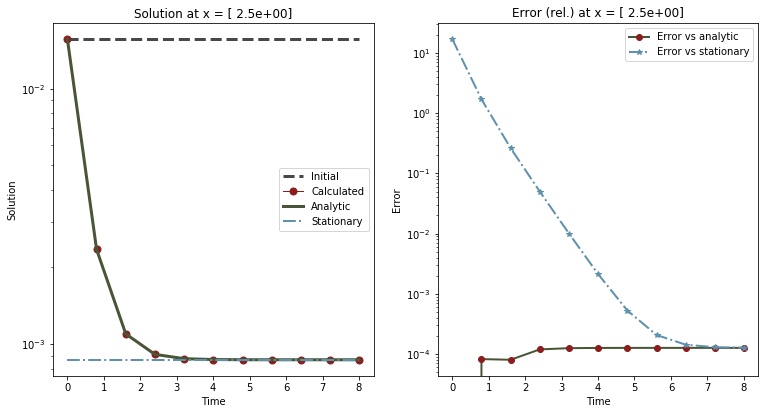

In [6]:
opts = { 'is_log': True, 'is_abs': False, 'is_err_abs': False, 'with_err_stat': True }
SL.plot_t(-2.5, opts)
SL.plot_t(+0.0, opts)
SL.plot_t(+2.5, opts)

<div class="head2">
    <div class="head2__name">
        Solution for different time moments
    </div>
</div>

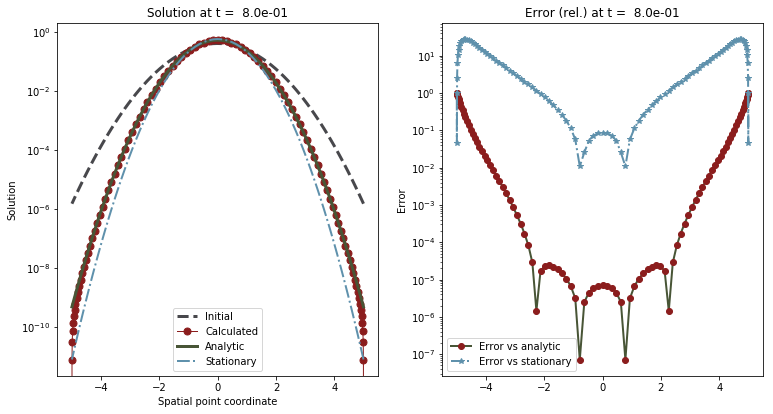

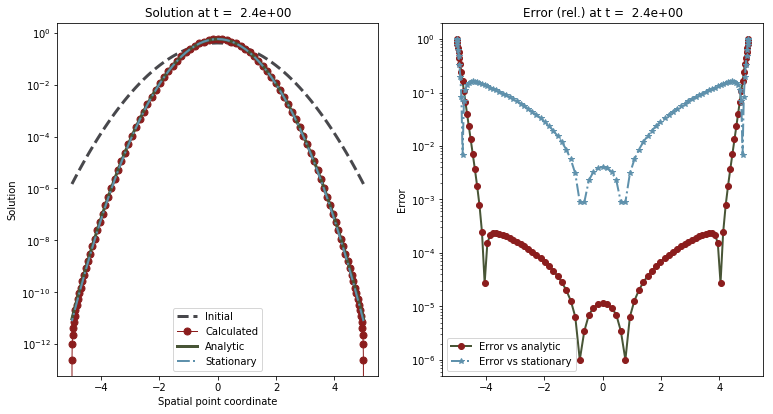

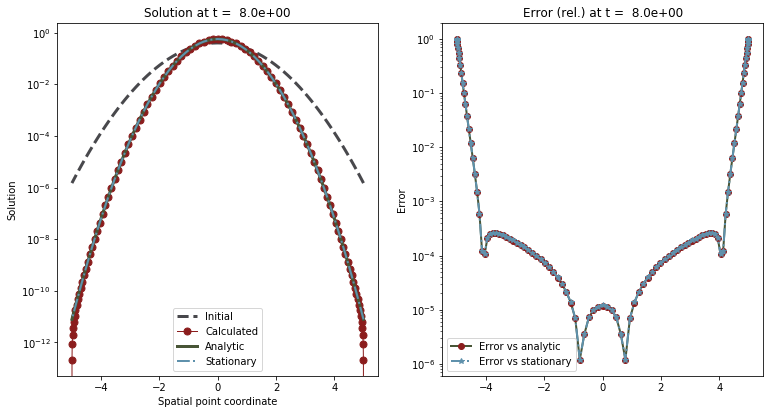

In [7]:
opts = { 'is_log': True, 'is_abs': False, 'is_err_abs': False, 'with_err_stat': True }
SL.plot_x(+0.1, opts)
SL.plot_x(+2.5, opts)
SL.plot_x(None, opts)

<div class="head1">
    <div class="head1__name">
        Results for multiple computations
    </div>
    <div class="head1__note">
        We use results that already saved to file (see computations code at the end of this file).
    </div>
</div>

In [8]:
SLC = SolversCheck(data_path)
SLC.load()

name1 = 'Solver (ord=1)'
name2 = 'Solver (ord=2)'

M = SLC.res[name2]['M']
N = SLC.res[name2]['N']

m = M[-1]
n = N[-1]

<div class="head2">
    <div class="head2__name">
        Dependence on the number of time points
    </div>
    <div class="head2__note">
        We present results for NP-solver of the 2th order.
    </div>
</div>

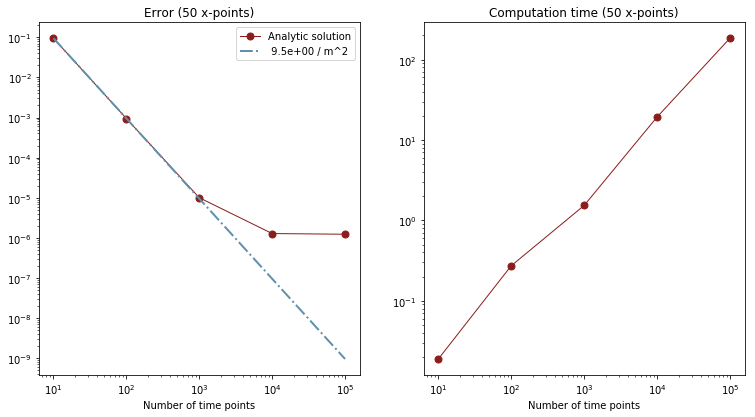

In [9]:
SLC.plot(name2, n=n, is_stat=False, is_xpoi=False, lims={ 'all': [0, None] })

<div class="head2">
    <div class="head2__name">
        Dependence on the number of spatial points
    </div>
    <div class="head2__note">
        We present results for NP-solver of the 2th order.
    </div>
</div>

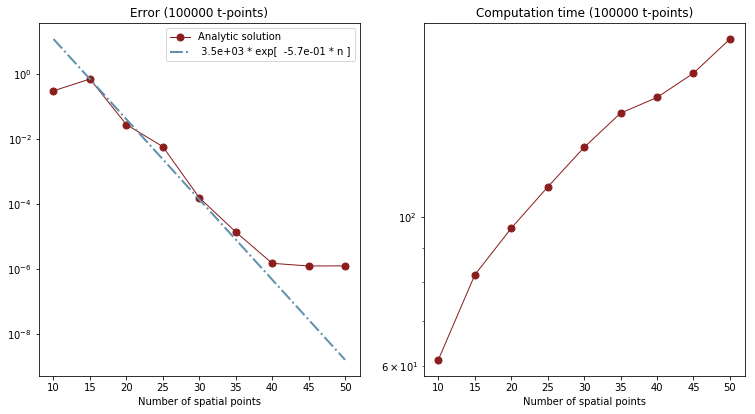

In [10]:
SLC.plot(name2, m=m, is_stat=False, is_xpoi=False, lims={ 'all': [1, None] })

<div class="head2">
    <div class="head2__name">
        Dependence on the solver order
    </div>
    <div class="head2__note">
        We present results (dependencies on the number of time and spatial points) for NP-solvers of various orders.
    </div>
</div>

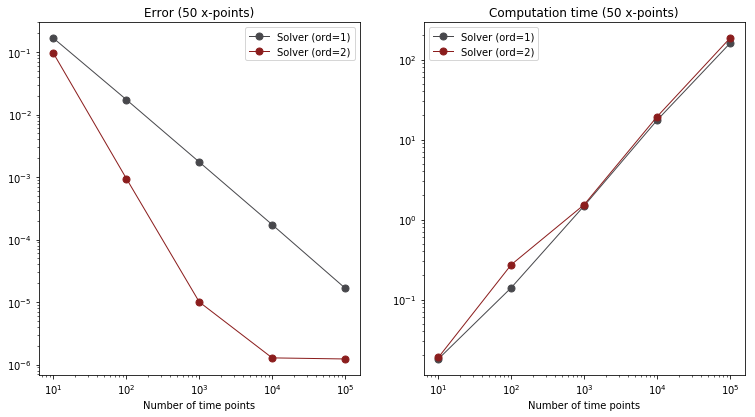

In [11]:
SLC.plot_all(n=n, is_stat=False, is_xpoi=False)

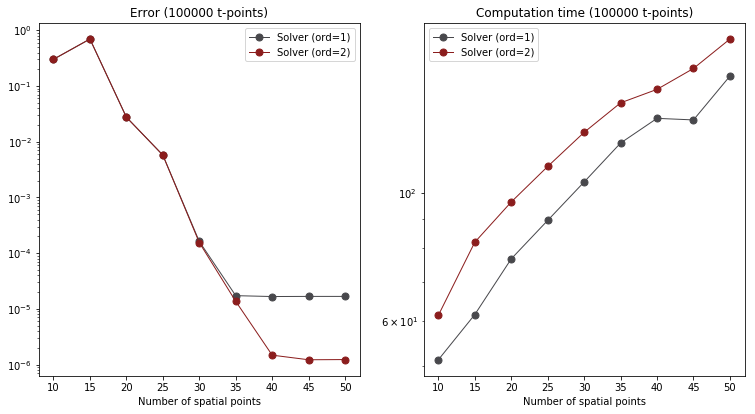

In [12]:
SLC.plot_all(m=m, is_stat=False, is_xpoi=False)

<div class="head1">
    <div class="head1__name">
        Explicit (simple) solvers
    </div>
    <div class="head1__note">
        Only for example and tests.
    </div>
</div>

In [13]:
import time
import numpy as np
import scipy.sparse as sp
from scipy.integrate import solve_ivp
from scipy.linalg import expm as expm
import matplotlib.pyplot as plt

from intertrain import Intertrain

In [14]:
d = 1
m = t_poi
n = x_poi
l = (x_max - x_min) / (x_poi - 1)
h = (t_max - t_min) / (t_poi - 1)
T = np.linspace(t_min, t_max, t_poi)

In [15]:
def show_x(X, r_calc, _time):
    X = X.reshape(1, -1)
    r_init = func_r0(X)
    r_real = func_rt(X, t_max)
    r_stat = func_rs(X)
    e = np.linalg.norm(r_real - r_calc) / np.linalg.norm(r_real)

    print('Number of spatial points : %8d'%x_poi)
    print('Number of time points    : %8d'%t_poi)
    print('Error (relative norm)    : %-12.2e'%e)
    print('Total time (sec)         : %-12.2e'%_time)
    print()
    
    plt.plot(
        X.reshape(-1), r_init, '--', label='Initial',
        linewidth=3, color='tab:blue'
    )
    plt.plot(
        X.reshape(-1), r_calc, label='Calculated',
        linewidth=1, color='tab:green', marker='o', markersize=7,
        markerfacecolor='lightgreen', markeredgecolor='g'
    )
    plt.plot(
        X.reshape(-1), r_real, label='Analytic',
        linewidth=3, color='black'
    )
    plt.plot(
        X.reshape(-1), r_stat, '--', label='Stationary',
        linewidth=2, color='magenta'
    )
    
    plt.title('Solution at the final time step')
    plt.xlabel('x')
    plt.ylabel('r')
    plt.legend(loc='best')
    plt.semilogy()
    plt.show()

<div class="head2">
    <div class="head2__name">
        Uniform spatial grid and the 1st order splitting
    </div>
</div>

We can solve equation on the uniform spatial grid for the time $t > 0$ with step $h$ and uniform spatial grid with step $l$ using 2th order finite difference scheme

$$
    \frac{\partial \rho}{\partial t} = (D + \widehat{Q}) \rho,
$$
where
$$
    \widehat{Q} \rho = f Q \rho - \frac{\partial f}{\partial x} \rho,
$$

$$
    D = \frac{D_{coef}}{l^2} tridiag \left( 1, -2, 1 \right),
    \quad
    Q = \frac{1}{2 l} tridiag \left( -1, 0, 1 \right).
$$

Let apply the 1th order splitting method on the time step $(k+1)$
$$
    \frac{\partial v}{\partial t} = D v,
    \quad
    v_{k} = \rho_{k},
    \quad
    v_{k+1} = v = ?,
$$
$$
    \frac{\partial w}{\partial t} = \widehat{Q} w,
    \quad
    w_{k} = v,
    \quad
    w_{k+1} = \rho_{k+1} = ?,
$$
and solve both ODEs by the 1th order Euler method.

Number of spatial points :      101
Number of time points    :     1000
Error (relative norm)    : 6.92e-03    
Total time (sec)         : 1.38e-01    



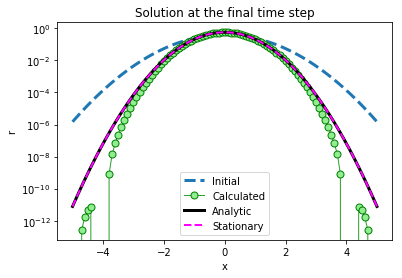

In [16]:
_time = time.time()

X = np.linspace(x_min, x_max, x_poi).reshape(1, -1)

Q = sp.spdiags([
        [-1.] * n,
        [+1.] * n
    ], [-1,  1], n, n).tocsr().toarray()
Q = Q * (0.5 / l)

D = sp.spdiags([
        [+1.] * x_poi,
        [-2.] * x_poi,
        [+1.] * x_poi
    ], [-1, 0, 1], x_poi, x_poi
).tocsr().toarray()
D = D * D_coef / l / l

J = np.eye(n); J[0, 0] = 0.; J[-1, -1] = 0.
ZD = h * D
ZQ = h * Q

r = func_r0(X)
r = r.reshape(-1, 1)
for t in T[1:]:
    F0 = np.diag(func_f0(X, t).reshape(-1))
    F1 = np.diag(func_f1(X, t).reshape(-1))
    v1 = r + ZD @ r
    w1 = v1 - F0 @ ZQ @ v1 - h * F1 @ v1
    r = w1

show_x(X, r.reshape(-1), time.time() - _time)

<div class="head1">
    <div class="head1__name">
        Multiple computations
    </div>
    <div class="head1__note">
        We compute dependencies of solution accuracy and calculation time on the number of time and spacial points and solver type. Results are saved to file and may be reused later for visualization.  
    </div>
</div>

In [15]:
if False: # Protection of already saved data
    SLC = SolversCheck(data_path)
    SLC.set_grid_t(t_min, t_max)
    SLC.set_grid_x(x_min, x_max)
    SLC.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
    SLC.set_coefs(D_coef)

    M = [10, 100, 1000, 10000, 100000]
    N = list(np.arange(10, 51, 5, dtype=int))
    SLC.add(name='Solver (ord=1)', d=1, eps=1.E-6, ord=1, with_tt=False, M=M, N=N)

    M = [10, 100, 1000, 10000, 100000]
    N = list(np.arange(10, 51, 5, dtype=int))
    SLC.add(name='Solver (ord=2)', d=1, eps=1.E-6, ord=2, with_tt=False, M=M, N=N)

    SLC.calc()
    SLC.save()

----- Calc for solver | "Solver (ord=1)"
----- Computation     | m = 10       | n = 10      


Solve: 100%|█| 9/9 [00:00<00:00, 871.49step/s, | At T=8.0e+00 : e=2.5e-02 es=2.5e-02]


----- Computation     | m = 10       | n = 15      


Solve: 100%|█| 9/9 [00:00<00:00, 748.75step/s, | At T=8.0e+00 : e=3.7e-01 es=3.7e-01]


----- Computation     | m = 10       | n = 20      


Solve: 100%|█| 9/9 [00:00<00:00, 844.21step/s, | At T=8.0e+00 : e=1.5e-01 es=1.5e-01]


----- Computation     | m = 10       | n = 25      


Solve: 100%|█| 9/9 [00:00<00:00, 880.27step/s, | At T=8.0e+00 : e=1.7e-01 es=1.7e-01]


----- Computation     | m = 10       | n = 30      


Solve: 100%|█| 9/9 [00:00<00:00, 772.26step/s, | At T=8.0e+00 : e=1.7e-01 es=1.7e-01]


----- Computation     | m = 10       | n = 35      


Solve: 100%|█| 9/9 [00:00<00:00, 623.52step/s, | At T=8.0e+00 : e=1.7e-01 es=1.7e-01]


----- Computation     | m = 10       | n = 40      


Solve: 100%|█| 9/9 [00:00<00:00, 474.08step/s, | At T=8.0e+00 : e=1.7e-01 es=1.7e-01]


----- Computation     | m = 10       | n = 45      


Solve: 100%|█| 9/9 [00:00<00:00, 673.70step/s, | At T=8.0e+00 : e=1.7e-01 es=1.7e-01]


----- Computation     | m = 10       | n = 50      


Solve: 100%|█| 9/9 [00:00<00:00, 467.47step/s, | At T=8.0e+00 : e=1.7e-01 es=1.7e-01]


----- Computation     | m = 100      | n = 10      


Solve: 100%|█| 99/99 [00:00<00:00, 1501.57step/s, | At T=8.0e+00 : e=1.5e+00 es=1.5e+00]


----- Computation     | m = 100      | n = 15      


Solve: 100%|█| 99/99 [00:00<00:00, 1413.90step/s, | At T=8.0e+00 : e=4.5e-01 es=4.5e-01]


----- Computation     | m = 100      | n = 20      


Solve: 100%|█| 99/99 [00:00<00:00, 1459.48step/s, | At T=8.0e+00 : e=2.1e-02 es=2.1e-02]


----- Computation     | m = 100      | n = 25      


Solve: 100%|█| 99/99 [00:00<00:00, 1285.13step/s, | At T=8.0e+00 : e=1.6e-02 es=1.6e-02]


----- Computation     | m = 100      | n = 30      


Solve: 100%|█| 99/99 [00:00<00:00, 1004.80step/s, | At T=8.0e+00 : e=1.7e-02 es=1.7e-02]


----- Computation     | m = 100      | n = 35      


Solve: 100%|█| 99/99 [00:00<00:00, 1035.41step/s, | At T=8.0e+00 : e=1.7e-02 es=1.7e-02]


----- Computation     | m = 100      | n = 40      


Solve: 100%|█| 99/99 [00:00<00:00, 807.14step/s, | At T=8.0e+00 : e=1.7e-02 es=1.7e-02]


----- Computation     | m = 100      | n = 45      


Solve: 100%|█| 99/99 [00:00<00:00, 740.57step/s, | At T=8.0e+00 : e=1.7e-02 es=1.7e-02]


----- Computation     | m = 100      | n = 50      


Solve: 100%|█| 99/99 [00:00<00:00, 705.30step/s, | At T=8.0e+00 : e=1.7e-02 es=1.7e-02]


----- Computation     | m = 1000     | n = 10      


Solve: 100%|█| 999/999 [00:00<00:00, 1904.00step/s, | At T=8.0e+00 : e=5.0e-01 es=5.0e-01]


----- Computation     | m = 1000     | n = 15      


Solve: 100%|█| 999/999 [00:00<00:00, 1542.09step/s, | At T=8.0e+00 : e=8.6e-01 es=8.6e-01]


----- Computation     | m = 1000     | n = 20      


Solve: 100%|█| 999/999 [00:00<00:00, 1287.12step/s, | At T=8.0e+00 : e=2.9e-02 es=2.9e-02]


----- Computation     | m = 1000     | n = 25      


Solve: 100%|█| 999/999 [00:00<00:00, 1027.10step/s, | At T=8.0e+00 : e=6.4e-03 es=6.4e-03]


----- Computation     | m = 1000     | n = 30      


Solve: 100%|█| 999/999 [00:00<00:00, 1095.52step/s, | At T=8.0e+00 : e=1.8e-03 es=1.8e-03]


----- Computation     | m = 1000     | n = 35      


Solve: 100%|█| 999/999 [00:01<00:00, 989.40step/s, | At T=8.0e+00 : e=1.7e-03 es=1.7e-03]


----- Computation     | m = 1000     | n = 40      


Solve: 100%|█| 999/999 [00:01<00:00, 843.09step/s, | At T=8.0e+00 : e=1.7e-03 es=1.7e-03]


----- Computation     | m = 1000     | n = 45      


Solve: 100%|█| 999/999 [00:01<00:00, 778.33step/s, | At T=8.0e+00 : e=1.7e-03 es=1.7e-03]


----- Computation     | m = 1000     | n = 50      


Solve: 100%|█| 999/999 [00:01<00:00, 667.89step/s, | At T=8.0e+00 : e=1.7e-03 es=1.7e-03]


----- Computation     | m = 10000    | n = 10      


Solve: 100%|█| 9999/9999 [00:04<00:00, 2046.49step/s, | At T=8.0e+00 : e=3.2e-01 es=3.2e-01]


----- Computation     | m = 10000    | n = 15      


Solve: 100%|█| 9999/9999 [00:06<00:00, 1482.44step/s, | At T=8.0e+00 : e=7.1e-01 es=7.1e-01]


----- Computation     | m = 10000    | n = 20      


Solve: 100%|█| 9999/9999 [00:08<00:00, 1225.72step/s, | At T=8.0e+00 : e=2.8e-02 es=2.8e-02]


----- Computation     | m = 10000    | n = 25      


Solve: 100%|█| 9999/9999 [00:10<00:00, 921.33step/s, | At T=8.0e+00 : e=5.9e-03 es=5.9e-03]


----- Computation     | m = 10000    | n = 30      


Solve: 100%|█| 9999/9999 [00:10<00:00, 975.57step/s, | At T=8.0e+00 : e=2.7e-04 es=2.7e-04] 


----- Computation     | m = 10000    | n = 35      


Solve: 100%|█| 9999/9999 [00:11<00:00, 835.04step/s, | At T=8.0e+00 : e=1.7e-04 es=1.7e-04]


----- Computation     | m = 10000    | n = 40      


Solve: 100%|█| 9999/9999 [00:15<00:00, 660.07step/s, | At T=8.0e+00 : e=1.7e-04 es=1.7e-04]


----- Computation     | m = 10000    | n = 45      


Solve: 100%|█| 9999/9999 [00:14<00:00, 690.99step/s, | At T=8.0e+00 : e=1.7e-04 es=1.7e-04]


----- Computation     | m = 10000    | n = 50      


Solve: 100%|█| 9999/9999 [00:17<00:00, 568.02step/s, | At T=8.0e+00 : e=1.7e-04 es=1.7e-04]


----- Computation     | m = 100000   | n = 10      


Solve: 100%|█| 99999/99999 [00:52<00:00, 1921.07step/s, | At T=8.0e+00 : e=3.0e-01 es=3.0e-01]


----- Computation     | m = 100000   | n = 15      


Solve: 100%|█| 99999/99999 [01:02<00:00, 1606.79step/s, | At T=8.0e+00 : e=7.0e-01 es=7.0e-01]


----- Computation     | m = 100000   | n = 20      


Solve: 100%|█| 99999/99999 [01:17<00:00, 1287.35step/s, | At T=8.0e+00 : e=2.8e-02 es=2.8e-02]


----- Computation     | m = 100000   | n = 25      


Solve: 100%|█| 99999/99999 [01:30<00:00, 1104.66step/s, | At T=8.0e+00 : e=5.8e-03 es=5.8e-03]


----- Computation     | m = 100000   | n = 30      


Solve: 100%|█| 99999/99999 [01:45<00:00, 947.65step/s, | At T=8.0e+00 : e=1.6e-04 es=1.6e-04] 


----- Computation     | m = 100000   | n = 35      


Solve: 100%|█| 99999/99999 [02:03<00:00, 811.35step/s, | At T=8.0e+00 : e=1.7e-05 es=1.7e-05]


----- Computation     | m = 100000   | n = 40      


Solve: 100%|█| 99999/99999 [02:15<00:00, 735.64step/s, | At T=8.0e+00 : e=1.7e-05 es=1.7e-05]


----- Computation     | m = 100000   | n = 45      


Solve: 100%|█| 99999/99999 [02:14<00:00, 741.17step/s, | At T=8.0e+00 : e=1.7e-05 es=1.7e-05]


----- Computation     | m = 100000   | n = 50      


Solve: 100%|█| 99999/99999 [02:40<00:00, 621.85step/s, | At T=8.0e+00 : e=1.7e-05 es=1.7e-05]


----- Done            | Time : 1.10e+03 sec
----- Calc for solver | "Solver (ord=2)"
----- Computation     | m = 10       | n = 10      


Solve: 100%|█| 9/9 [00:00<00:00, 909.45step/s, | At T=8.0e+00 : e=8.9e-01 es=8.9e-01]


----- Computation     | m = 10       | n = 15      


Solve: 100%|█| 9/9 [00:00<00:00, 766.21step/s, | At T=8.0e+00 : e=2.6e+00 es=2.6e+00]


----- Computation     | m = 10       | n = 20      


Solve: 100%|█| 9/9 [00:00<00:00, 809.43step/s, | At T=8.0e+00 : e=1.5e-01 es=1.5e-01]


----- Computation     | m = 10       | n = 25      


Solve: 100%|█| 9/9 [00:00<00:00, 622.28step/s, | At T=8.0e+00 : e=8.9e-02 es=8.9e-02]


----- Computation     | m = 10       | n = 30      


Solve: 100%|█| 9/9 [00:00<00:00, 659.69step/s, | At T=8.0e+00 : e=9.5e-02 es=9.5e-02]


----- Computation     | m = 10       | n = 35      


Solve: 100%|█| 9/9 [00:00<00:00, 425.86step/s, | At T=8.0e+00 : e=9.5e-02 es=9.5e-02]


----- Computation     | m = 10       | n = 40      


Solve: 100%|█| 9/9 [00:00<00:00, 685.44step/s, | At T=8.0e+00 : e=9.5e-02 es=9.5e-02]


----- Computation     | m = 10       | n = 45      


Solve: 100%|█| 9/9 [00:00<00:00, 482.60step/s, | At T=8.0e+00 : e=9.5e-02 es=9.5e-02]


----- Computation     | m = 10       | n = 50      


Solve: 100%|█| 9/9 [00:00<00:00, 493.72step/s, | At T=8.0e+00 : e=9.5e-02 es=9.5e-02]


----- Computation     | m = 100      | n = 10      


Solve: 100%|█| 99/99 [00:00<00:00, 1507.22step/s, | At T=8.0e+00 : e=1.6e+00 es=1.6e+00]


----- Computation     | m = 100      | n = 15      


Solve: 100%|█| 99/99 [00:00<00:00, 1427.05step/s, | At T=8.0e+00 : e=5.5e-01 es=5.5e-01]


----- Computation     | m = 100      | n = 20      


Solve: 100%|█| 99/99 [00:00<00:00, 1218.97step/s, | At T=8.0e+00 : e=1.8e-02 es=1.8e-02]


----- Computation     | m = 100      | n = 25      


Solve: 100%|█| 99/99 [00:00<00:00, 684.34step/s, | At T=8.0e+00 : e=3.7e-03 es=3.7e-03]


----- Computation     | m = 100      | n = 30      


Solve: 100%|█| 99/99 [00:00<00:00, 843.36step/s, | At T=8.0e+00 : e=8.9e-04 es=8.9e-04]


----- Computation     | m = 100      | n = 35      


Solve: 100%|█| 99/99 [00:00<00:00, 709.49step/s, | At T=8.0e+00 : e=9.4e-04 es=9.4e-04]


----- Computation     | m = 100      | n = 40      


Solve: 100%|█| 99/99 [00:00<00:00, 458.66step/s, | At T=8.0e+00 : e=9.5e-04 es=9.5e-04]


----- Computation     | m = 100      | n = 45      


Solve: 100%|█| 99/99 [00:00<00:00, 539.68step/s, | At T=8.0e+00 : e=9.5e-04 es=9.5e-04]


----- Computation     | m = 100      | n = 50      


Solve: 100%|█| 99/99 [00:00<00:00, 356.82step/s, | At T=8.0e+00 : e=9.5e-04 es=9.5e-04]


----- Computation     | m = 1000     | n = 10      


Solve: 100%|█| 999/999 [00:00<00:00, 1394.93step/s, | At T=8.0e+00 : e=5.0e-01 es=5.0e-01]


----- Computation     | m = 1000     | n = 15      


Solve: 100%|█| 999/999 [00:00<00:00, 1214.82step/s, | At T=8.0e+00 : e=8.7e-01 es=8.7e-01]


----- Computation     | m = 1000     | n = 20      


Solve: 100%|█| 999/999 [00:00<00:00, 1011.49step/s, | At T=8.0e+00 : e=3.0e-02 es=3.0e-02]


----- Computation     | m = 1000     | n = 25      


Solve: 100%|█| 999/999 [00:01<00:00, 990.54step/s, | At T=8.0e+00 : e=5.6e-03 es=5.6e-03] 


----- Computation     | m = 1000     | n = 30      


Solve: 100%|█| 999/999 [00:01<00:00, 803.75step/s, | At T=8.0e+00 : e=1.2e-04 es=1.2e-04]


----- Computation     | m = 1000     | n = 35      


Solve: 100%|█| 999/999 [00:01<00:00, 817.85step/s, | At T=8.0e+00 : e=1.3e-05 es=1.3e-05]


----- Computation     | m = 1000     | n = 40      


Solve: 100%|█| 999/999 [00:01<00:00, 721.24step/s, | At T=8.0e+00 : e=1.0e-05 es=1.0e-05]


----- Computation     | m = 1000     | n = 45      


Solve: 100%|█| 999/999 [00:01<00:00, 603.00step/s, | At T=8.0e+00 : e=1.0e-05 es=1.0e-05]


----- Computation     | m = 1000     | n = 50      


Solve: 100%|█| 999/999 [00:01<00:00, 645.05step/s, | At T=8.0e+00 : e=1.0e-05 es=1.0e-05]


----- Computation     | m = 10000    | n = 10      


Solve: 100%|█| 9999/9999 [00:06<00:00, 1557.19step/s, | At T=8.0e+00 : e=3.2e-01 es=3.2e-01]


----- Computation     | m = 10000    | n = 15      


Solve: 100%|█| 9999/9999 [00:07<00:00, 1279.27step/s, | At T=8.0e+00 : e=7.2e-01 es=7.2e-01]


----- Computation     | m = 10000    | n = 20      


Solve: 100%|█| 9999/9999 [00:10<00:00, 997.84step/s, | At T=8.0e+00 : e=2.8e-02 es=2.8e-02] 


----- Computation     | m = 10000    | n = 25      


Solve: 100%|█| 9999/9999 [00:11<00:00, 899.83step/s, | At T=8.0e+00 : e=5.8e-03 es=5.8e-03]


----- Computation     | m = 10000    | n = 30      


Solve: 100%|█| 9999/9999 [00:12<00:00, 828.81step/s, | At T=8.0e+00 : e=1.6e-04 es=1.6e-04]


----- Computation     | m = 10000    | n = 35      


Solve: 100%|█| 9999/9999 [00:13<00:00, 716.84step/s, | At T=8.0e+00 : e=1.4e-05 es=1.4e-05]


----- Computation     | m = 10000    | n = 40      


Solve: 100%|█| 9999/9999 [00:16<00:00, 622.24step/s, | At T=8.0e+00 : e=1.5e-06 es=1.5e-06]


----- Computation     | m = 10000    | n = 45      


Solve: 100%|█| 9999/9999 [00:17<00:00, 562.15step/s, | At T=8.0e+00 : e=1.3e-06 es=1.3e-06]


----- Computation     | m = 10000    | n = 50      


Solve: 100%|█| 9999/9999 [00:19<00:00, 512.66step/s, | At T=8.0e+00 : e=1.3e-06 es=1.3e-06]


----- Computation     | m = 100000   | n = 10      


Solve: 100%|█| 99999/99999 [01:02<00:00, 1611.02step/s, | At T=8.0e+00 : e=3.0e-01 es=3.0e-01]


----- Computation     | m = 100000   | n = 15      


Solve: 100%|█| 99999/99999 [01:23<00:00, 1203.35step/s, | At T=8.0e+00 : e=7.0e-01 es=7.0e-01]


----- Computation     | m = 100000   | n = 20      


Solve: 100%|█| 99999/99999 [01:37<00:00, 1025.38step/s, | At T=8.0e+00 : e=2.8e-02 es=2.8e-02]


----- Computation     | m = 100000   | n = 25      


Solve: 100%|█| 99999/99999 [01:52<00:00, 890.15step/s, | At T=8.0e+00 : e=5.8e-03 es=5.8e-03]


----- Computation     | m = 100000   | n = 30      


Solve: 100%|█| 99999/99999 [02:08<00:00, 776.68step/s, | At T=8.0e+00 : e=1.6e-04 es=1.5e-04]


----- Computation     | m = 100000   | n = 35      


Solve: 100%|█| 99999/99999 [02:24<00:00, 690.62step/s, | At T=8.0e+00 : e=1.4e-05 es=1.4e-05]


----- Computation     | m = 100000   | n = 40      


Solve: 100%|█| 99999/99999 [02:32<00:00, 655.39step/s, | At T=8.0e+00 : e=1.5e-06 es=1.5e-06]


----- Computation     | m = 100000   | n = 45      


Solve: 100%|█| 99999/99999 [02:45<00:00, 603.01step/s, | At T=8.0e+00 : e=1.2e-06 es=1.2e-06]


----- Computation     | m = 100000   | n = 50      


Solve: 100%|█| 99999/99999 [03:06<00:00, 536.00step/s, | At T=8.0e+00 : e=1.2e-06 es=1.3e-06]


----- Done            | Time : 1.31e+03 sec


<div class="head1">
    <div class="head1__name">
        Plots for the paper
    </div>
</div>

In [5]:
import sys
import numpy as np
import matplotlib as mpl

mpl.rc('font', **{'size'   : 18})
mpl.rcParams.update({
    "font.family": "normal",
    "font.serif": [],
    "font.sans-serif": [],
    "font.monospace": [],
})
mpl.rcParams['text.usetex'] = True

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

sns.set_context('paper', font_scale=3.0)
sns.set_style('white')
sns.mpl.rcParams['legend.frameon'] = 'False'

sys.path.extend(['./../lib', './../helpers'])
from config import config
from solver import Solver
from solvers_check import SolversCheck

In [16]:
pal = sns.color_palette()

data_path = './data/eq-1d_drift-linear_analyt'
figs_path = './../../paper_fpcross/text/fig_'

name1 = 'Solver (ord=1)'
name2 = 'Solver (ord=2)'

line_calc = {
    'linestyle': '-',
    'linewidth': 1,
    'color': '#8b1d1d',
    'marker': 'o',
    'markersize': 7,
    'markerfacecolor': '#8b1d1d',
    'markeredgewidth': 1,
    'markeredgecolor': '#8b1d1d',
}
line_appr = {
    'linestyle': '-.',
    'linewidth': 2,
    'color': '#5f91ac',
    'marker': 'o',
    'markersize': 0,
    'markerfacecolor': '#5f91ac',
    'markeredgewidth': 0,
    'markeredgecolor': '#5f91ac',
}

SLC = SolversCheck(data_path)
SLC.load()

M = SLC.res[name2]['M'].copy()
N = SLC.res[name2]['N'].copy()

<div class="head2">
    <div class="head2__name">
        Error (real) vs number of time points for the 2th order solver
    </div>
</div>

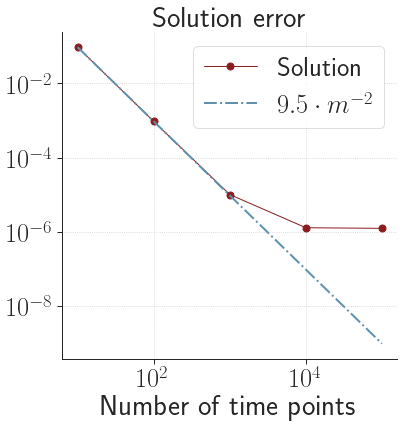

In [17]:
n = N[-1]
x = np.array(M)
y = np.array([SLC.res[name2]['%d-%d'%(m, n)]['err'] for m in M])

# a, b = np.polyfit(1./x**2, y, 1)
a = +9.5E+0
z = a / x**2
s_appr = r'$9.5 \cdot m^{-2}$'

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

ax.plot(x, y, label='Solution', **line_calc)
ax.plot(x, z, label=s_appr, **line_appr)
ax.set_title('Solution error')
ax.set_xlabel('Number of time points')
ax.set_ylabel('')
ax.semilogx()
ax.semilogy()           
ax.grid(ls=":")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.legend(loc='best', frameon=True)

plt.savefig(figs_path + 'eq-1d_drift-linear_analyt_e-vs-m.pgf', bbox_inches='tight')

<div class="head2">
    <div class="head2__name">
        Computation time vs number of time points for the 2th order solver
    </div>
</div>

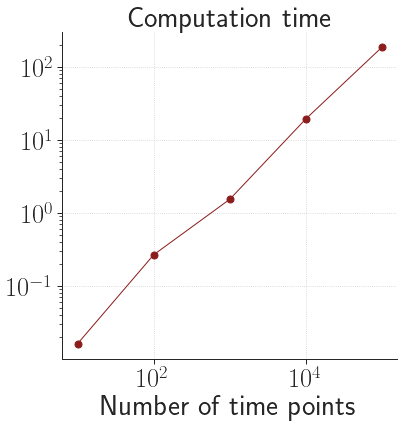

In [18]:
n = N[-1]
x = np.array(M)
y = np.array([SLC.res[name2]['%d-%d'%(m, n)]['t_calc'] for m in M])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

ax.plot(x, y, label='Solution', **line_calc)
ax.set_title('Computation time')
ax.set_xlabel('Number of time points')
ax.set_ylabel('')
ax.semilogx()
ax.semilogy()           
ax.grid(ls=":")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt.savefig(figs_path + 'eq-1d_drift-linear_analyt_t-vs-m.pgf', bbox_inches='tight')

<div class="head2">
    <div class="head2__name">
        Error vs number of spatial points (2th order solver)
    </div>
</div>

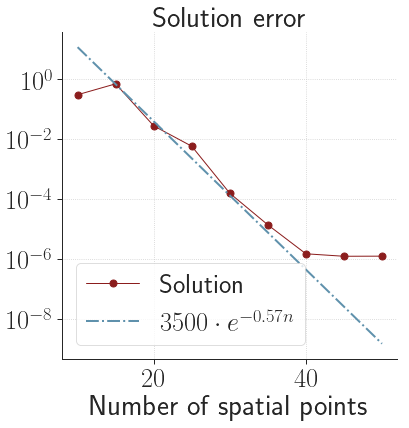

In [19]:
m = M[-1]
x = np.array(N, dtype='float')
y = np.array([SLC.res[name2]['%d-%d'%(m, n)]['err'] for n in N])

# b, a = np.polyfit(x[1:None], np.log(x[1:None]), 1, w=np.sqrt(y[1:None]))
# a = np.exp(a)
# s_appr = '%8.1e * exp[ %9.1e * n ]'%(a, b)

a = +3.5E+3
b = -5.7E-1
z = a * np.exp(b * x)
s_appr = '$3500 \cdot e^{-0.57 n}$'

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

ax.plot(x, y, label='Solution', **line_calc)
ax.plot(x, z, label=s_appr, **line_appr)
ax.set_title('Solution error')
ax.set_xlabel('Number of spatial points')
ax.set_ylabel('')
ax.semilogy()           
ax.grid(ls=":")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.legend(loc='best', frameon=True)

plt.savefig(figs_path + 'eq-1d_drift-linear_analyt_e-vs-n.pgf', bbox_inches='tight')

<div class="head2">
    <div class="head2__name">
        Computation time vs number of spatial points for the 2th order solver
    </div>
</div>

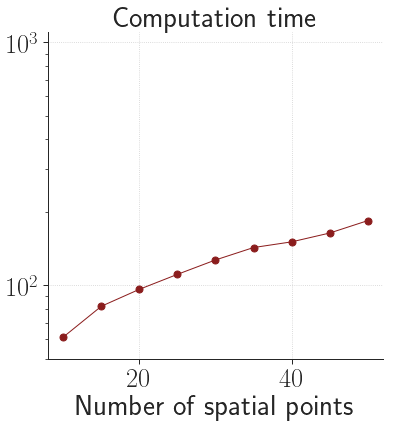

In [20]:
m = M[-1]
x = np.array(N)
y = np.array([SLC.res[name2]['%d-%d'%(m, n)]['t_calc'] for n in N])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

ax.plot(x, y, label='Solution', **line_calc)
ax.set_ylim(5.0E+1, 1.1E+3)
ax.set_title('Computation time')
ax.set_xlabel('Number of spatial points')
ax.set_ylabel('')
ax.semilogy()           
ax.grid(ls=":")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt.savefig(figs_path + 'eq-1d_drift-linear_analyt_t-vs-n.pgf', bbox_inches='tight')

<div class="head2">
    <div class="head2__name">
        Solution in the central spatial point vs time
    </div>
</div>

In [21]:
line_init = {
    'linestyle': '--',
    'linewidth': 3,
    'color': '#48484c',
    'marker': 'o',
    'markersize': 0,
    'markerfacecolor': '#48484c',
    'markeredgewidth': 0,
    'markeredgecolor': '#48484c',
}
line_calc = {
    'linestyle': '-',
    'linewidth': 1,
    'color': '#8b1d1d',
    'marker': 'o',
    'markersize': 7,
    'markerfacecolor': '#8b1d1d',
    'markeredgewidth': 1,
    'markeredgecolor': '#8b1d1d',
}
line_real = {
    'linestyle': '-',
    'linewidth': 3,
    'color': '#485536',
    'marker': 'o',
    'markersize': 0,
    'markerfacecolor': '#485536',
    'markeredgewidth': 0,
    'markeredgecolor': '#485536',
}
line_stat = {
    'linestyle': '-.',
    'linewidth': 2,
    'color': '#5f91ac',
    'marker': 'o',
    'markersize': 0,
    'markerfacecolor': '#5f91ac',
    'markeredgewidth': 0,
    'markeredgecolor': '#5f91ac',
}
line_err_real = {
    'linestyle': '-',
    'linewidth': 2,
    'color': '#485536',
    'marker': 'o',
    'markersize': 6,
    'markerfacecolor': '#8b1d1d',
    'markeredgewidth': 1,
    'markeredgecolor': '#8b1d1d',
}
line_err_stat = {
    'linestyle': '-.',
    'linewidth': 2,
    'color': '#5f91ac',
    'marker': '*',
    'markersize': 6,
    'markerfacecolor': '#5f91ac',
    'markeredgewidth': 1,
    'markeredgecolor': '#5f91ac',
}

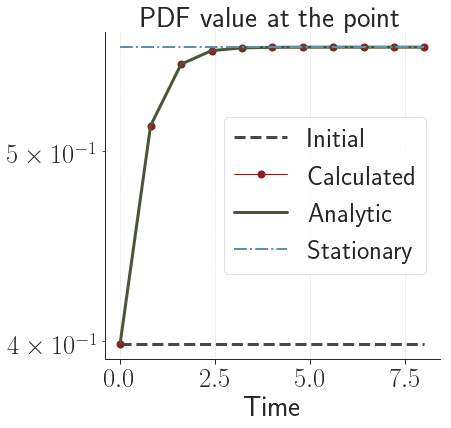

In [22]:
x = np.array([0.])
i = SL._sind(x)
x = SL.X_hst[:, i].reshape(-1, 1)
t = SL.T_hst
v = np.ones(t.shape[0])

r_init = v * SL.func_r0(x)[0]
r_stat = v * SL.func_rs(x)[0]
r_real = np.array([SL.func_rt(x, t_)[0] for t_ in t])
r_calc = np.array([r[i] for r in SL.R_hst])

x = [SL.t_min] + list(t)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

ax.plot(x, [r_init[0]] + list(r_init), label='Initial', **line_init)
ax.plot(x, [r_init[0]] + list(r_calc), label='Calculated', **line_calc)
ax.plot(x, [r_init[0]] + list(r_real), label='Analytic', **line_real)
ax.plot(x, [r_stat[0]] + list(r_stat), label='Stationary', **line_stat)

ax.set_title('PDF value at the point')
ax.set_xlabel('Time')
ax.semilogy()           
ax.grid(ls=":")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.legend(loc='best', frameon=True)

plt.savefig(figs_path + 'eq-1d_drift-linear_analyt_x-zero-vs-t-res.pgf', bbox_inches='tight')

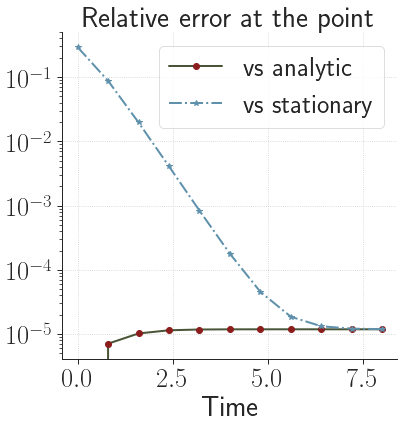

In [23]:
e0 = np.abs(r_stat[0] - r_init[0]) / np.abs(r_stat[0])
e_stat = [e0] + list(np.abs(r_stat - r_calc) / np.abs(r_stat))
e_real = [0.] + list(np.abs(r_real - r_calc) / np.abs(r_real))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

ax.plot(x, e_real, label='vs analytic', **line_err_real)
ax.plot(x, e_stat, label='vs stationary', **line_err_stat)

ax.set_title('Relative error at the point')
ax.set_xlabel('Time')
ax.semilogy()           
ax.grid(ls=":")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.legend(loc='best', frameon=True)

plt.savefig(figs_path + 'eq-1d_drift-linear_analyt_x-zero-vs-t-err.pgf', bbox_inches='tight')

<div class="head2">
    <div class="head2__name">
        Solution at the final time moment
    </div>
</div>

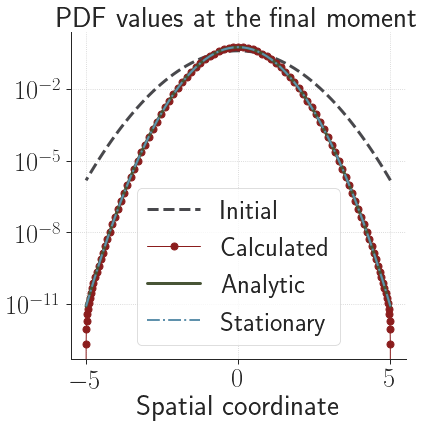

In [24]:
i = -1
t = SL.T_hst[i]
x = SL.X_hst

r_init = SL.func_r0(x)
r_stat = SL.func_rs(x)
r_real = SL.func_rt(x, t)
r_calc = SL.R_hst[i]

x = x.reshape(-1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

ax.plot(x, r_init, label='Initial', **line_init)
ax.plot(x, r_calc, label='Calculated', **line_calc)
ax.plot(x, r_real, label='Analytic', **line_real)
ax.plot(x, r_stat, label='Stationary', **line_stat)

ax.set_title('PDF values at the final moment')
ax.set_xlabel('Spatial coordinate')
ax.semilogy()           
ax.grid(ls=":")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.legend(loc='best', frameon=True)

plt.savefig(figs_path + 'eq-1d_drift-linear_analyt_t-end-vs-x-res.pgf', bbox_inches='tight')

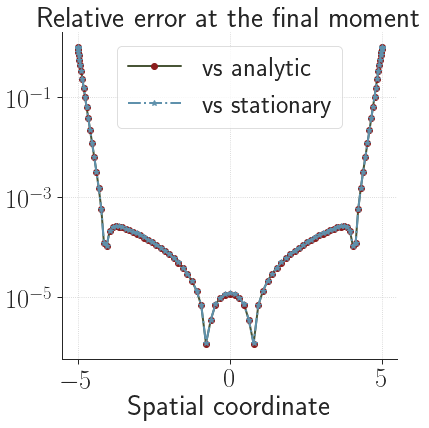

In [25]:
e_real = np.abs(r_real - r_calc) / np.abs(r_real)
e_stat = np.abs(r_stat - r_calc) / np.abs(r_stat)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

ax.plot(x, e_real, label='vs analytic', **line_err_real)
ax.plot(x, e_stat, label='vs stationary', **line_err_stat)

ax.set_title('Relative error at the final moment')
ax.set_xlabel('Spatial coordinate')
ax.semilogy()           
ax.grid(ls=":")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.legend(loc='best', frameon=True)

plt.savefig(figs_path + 'eq-1d_drift-linear_analyt_t-end-vs-x-err.pgf', bbox_inches='tight')

<div class="end"></div>